In [186]:
import matplotlib
from delaunay_triangulations import Player, get_points_of_defenders, returner, get_lines_from_delaunay, \
    get_arrival_times, get_defensive_locations
# matplotlib.use("TkAgg")
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay, ConvexHull, convex_hull_plot_2d
from helpers import get_play_description_from_number, inputpath, playpath
import time



def drawPitch(width, height, color="black"):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, width + 30), ylim=(-15, height + 5))
    plt.axis('off')

    # Grass around pitch
    rect = patches.Rectangle((-10, -5), width + 40, height + 10, linewidth=1, facecolor='#ddede5', capstyle='round')
    ax.add_patch(rect)
    ###################

    # Pitch boundaries
    rect = plt.Rectangle((0, 0), width + 20, height, ec=color, fc="None", lw=2)
    ax.add_patch(rect)
    ###################
    # vertical lines - every 5 yards
    for i in range(21):
        plt.plot([10 + 5 * i, 10 + 5 * i], [0, height], c="black", lw=2)
    ###################

    # distance markers - every 10 yards
    for yards in range(10, width, 10):
        yards_text = yards if yards <= width / 2 else width - yards
        # top markers
        plt.text(10 + yards - 2, height - 7.5, yards_text, size=20, c="black")
        # botoom markers
        plt.text(10 + yards - 2, 7.5, yards_text, size=20, c="black", rotation=180)
    ###################
        # yards markers - every yard
        # bottom markers
        for x in range(20):
            for j in range(1, 5):
                plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [1, 3], color="black", lw=3)

        # top markers
        for x in range(20):
            for j in range(1, 5):
                plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - 1, height - 3], color="black", lw=3)

        # middle bottom markers
        y = (height - 18.5) / 2
        for x in range(20):
            for j in range(1, 5):
                plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [y, y + 2], color="black", lw=3)
    # middle top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - y, height - y - 2], color="black", lw=3)
    ###################

    # draw home end zone
    plt.text(2.5, (height - 10) / 2, "HOME", size=40, c="w", weight="bold", rotation=90)
    rect = plt.Rectangle((0, 0), 10, height, ec=color, fc="#0064dc", lw=2)
    ax.add_patch(rect)

    # draw away end zone
    plt.text(112.5, (height - 10) / 2, "AWAY", size=40, c="w", weight="bold", rotation=-90)
    rect = plt.Rectangle((width + 10, 0), 10, height, ec=color, fc="#c80014", lw=2)
    ax.add_patch(rect)
    ###################

    # draw extra spot point
    # left
    y = (height - 3) / 2
    plt.plot([10 + 2, 10 + 2], [y, y + 3], c="black", lw=2)

    # right
    plt.plot([width + 10 - 2, width + 10 - 2], [y, y + 3], c="black", lw=2)
    ###################

    # draw goalpost
    goal_width = 6  # yards
    y = (height - goal_width) / 2
    # left
    plt.plot([0, 0], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    # right
    plt.plot([width + 20, width + 20], [y, y + goal_width], "-", c="black", lw=10, ms=20)

    return fig, ax


def extract_one_game(game):
    home = {}
    away = {}
    balls = []

    players = game.sort_values(['frameId'], ascending=True).groupby('nflId')
    for id, dx in players:
        jerseyNumber = int(dx.jerseyNumber.iloc[0])
        if dx.team.iloc[0] == "home":
            home[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))
        elif dx.team.iloc[0] == "away":
            away[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))

    ball_df = game.sort_values(['frameId'], ascending=True)
    ball_df = ball_df[ball_df.team == "football"]
    balls = list(zip(ball_df.x.tolist(), ball_df.y.tolist()))
    return home, away, balls




def process_frames(csv, delaunay=False):

    receive_frame = csv[csv['event'] == 'punt_received']['frameId'].iloc[0]
    punt_returner = returner(csv, receive_frame)
    attacking_team = csv[csv['displayName'] == punt_returner]['team'].iloc[0]
    attackers = []
    defenders = []

    for player in np.unique(csv['displayName']):
        player_csv = csv[csv['displayName'] == player][receive_frame:]
        size = np.shape(player_csv)[0]
        #size = 10
        team = csv[csv['displayName'] == player]['team'].iloc[0]
        if team == attacking_team:
            attackers.append(Player(player, player_csv['x'], player_csv['y'], team, 0.6))
        elif team != "football":
            defenders.append(Player(player, player_csv['x'], player_csv['y'], team, 0.6))

    returner_pos = csv[csv['displayName'] == punt_returner][receive_frame:]
    returner_pos = list(zip(returner_pos.x.tolist(), returner_pos.y.tolist()))


    ball_df = csv.sort_values(['frameId'], ascending=True)
    ball_df = ball_df[ball_df.team == "football"][receive_frame:]
    balls = list(zip(ball_df.x.tolist(), ball_df.y.tolist()))
    fig, ax = drawPitch(100, 53.3)

    #DO CALC BEFORE TO SPEED UP VISUALS
    points_def = []
    points_off = []
    lines = []
    times = []
    bound_points_x =[]
    bound_points_y = []
    outer_layer_x = []
    outer_layer_y = []

    start_time = time.time()
    # Get data before for smooth animation
    for frame in range(size):
        print("Processed frame", frame, "/",size,"||",round((frame/size)*100,3),"%")
        points_def.append(np.array(get_points_of_defenders(defenders, frame)))
        points_off.append(np.array(get_points_of_defenders(attackers, frame)))
        if delaunay:
            bounds = ConvexHull(points_def[frame]).vertices
            for element in bounds:
                bound_points_x.append(points_def[frame][element][0])
                bound_points_y.append(points_def[frame][element][1])

            outer_layer_x.append(bound_points_x)
            outer_layer_y.append(bound_points_y)
            bound_points_x = []
            bound_points_y = []

        tri = Delaunay(points_def[frame])
        lines.append(get_lines_from_delaunay(tri, defenders,frame))
        times.append(get_arrival_times(lines[frame], defenders, attackers,frame))
    end_time = time.time()
    print("Took",round(end_time-start_time,2),"s to process",size,"frames")
    return size, returner_pos, points_def, points_off, balls, lines, times, outer_layer_x, outer_layer_y


    


def animate_frames(size, returner_pos, points_def, points_off, balls, lines,times, outer_layer_x, outer_layer_y, delaunay):
    print("?")
    fig, ax = drawPitch(100, 53.3)



    for frame in range(size):
        # PLOT EVERYTHING
        retur = ax.text(returner_pos[frame][0]-0.5, returner_pos[frame][1]-0.5, 'R', zorder=15, c="pink")

        return_line, = ax.plot([returner_pos[frame][0], returner_pos[frame][0]], [0, 53.3], "--", zorder=5, c="black")

        defensive, = ax.plot(points_def[frame][:, 0], points_def[frame][:, 1], 'o', markersize=10, markerfacecolor="r",
                             markeredgewidth=1, markeredgecolor="white",
                             zorder=5, label='Defenders')
        offensive, = ax.plot(points_off[frame][:, 0], points_off[frame][:, 1], 'o', markersize=10, markerfacecolor="b",
                             markeredgewidth=1, markeredgecolor="white",
                             zorder=5, label='Attackers')
        ball, = ax.plot(balls[frame][0], balls[frame][1], 'o', markersize=8, markerfacecolor="black", markeredgewidth=1, markeredgecolor="white",
                        zorder=10)




        # triang = ax.triplot(*points_def.T, tri.simplices, color="black")
        if delaunay:
            p = ax.scatter(lines[frame][:, 0], lines[frame][:, 1], c=times[frame], cmap="YlOrRd", marker="s", s=5, zorder=15)
            out_layer, = ax.plot(outer_layer_x[frame], outer_layer_y[frame], 'o',markersize=4, markerfacecolor="purple", zorder=15)


            if frame < size - 1:
                plt.pause(0.05)
                if delaunay:
                    p.remove()
                    out_layer.remove()
                    return_line.remove()
                    offensive.remove()
                    defensive.remove()
                    ball.remove()
                    retur.remove()

                    #triang[0].remove()
                    #triang[1].remove()

        plt.show()

def visualise_play(playpath_, changeFigsize=False):
    if changeFigsize:
        plt.rcParams['figure.figsize'] = [36, 20]
    csv = pd.read_csv(playpath_)
    animate_return(csv, delaunay=True)

# Identify the delaunay triangles within the defensive structure

# Draw the delaunay triangles frame by frame

def visualise_delaunay_play(playpath_, size):
    fig, ax = plt.subplots()
    for frame in range(size):
        attackers, defenders = get_defensive_locations(playpath_)
        points_def = np.array(get_points_of_defenders(defenders, frame))
        arrival_points = None
        points_off = np.array(get_points_of_defenders(attackers, frame))
        tri = Delaunay(points_def)
        lines = get_lines_from_delaunay(tri,points_def)
        times = get_arrival_times(lines,points_def,points_off)
        
        plt.triplot(points_def[:,0], points_def[:,1], tri.simplices)
        plt.plot(points_def[:,0], points_def[:,1], 'o', c='r',label='Defenders')
        plt.plot(points_off[:,0], points_off[:,1], 'o', c='b', label='Attackers')
        p = plt.scatter(lines[:,0],lines[:,1],c=times, cmap = "RdYlGn",marker="s",s=5)
        cbar = fig.colorbar(p)
        cbar.set_label("Expected defender arrival time (s)")
        plt.legend(loc='best')
        plt.xlim([0, 120])
        plt.ylim([0, 53.3])
        plt.xlabel('x')
        plt.ylabel('y')
        if frame < size-1:
            plt.pause(0.05)
            ax.clear()
            fig.clear()
    plt.show()



#visualise_delaunay_play(playpath)
# visualise_play(playpath)


Processed frame 0 / 50 || 0.0 %
Processed frame 1 / 50 || 2.0 %
Processed frame 2 / 50 || 4.0 %
Processed frame 3 / 50 || 6.0 %
Processed frame 4 / 50 || 8.0 %
Processed frame 5 / 50 || 10.0 %
Processed frame 6 / 50 || 12.0 %
Processed frame 7 / 50 || 14.0 %
Processed frame 8 / 50 || 16.0 %
Processed frame 9 / 50 || 18.0 %
Processed frame 10 / 50 || 20.0 %
Processed frame 11 / 50 || 22.0 %
Processed frame 12 / 50 || 24.0 %
Processed frame 13 / 50 || 26.0 %
Processed frame 14 / 50 || 28.0 %
Processed frame 15 / 50 || 30.0 %
Processed frame 16 / 50 || 32.0 %
Processed frame 17 / 50 || 34.0 %
Processed frame 18 / 50 || 36.0 %
Processed frame 19 / 50 || 38.0 %
Processed frame 20 / 50 || 40.0 %
Processed frame 21 / 50 || 42.0 %
Processed frame 22 / 50 || 44.0 %
Processed frame 23 / 50 || 46.0 %
Processed frame 24 / 50 || 48.0 %
Processed frame 25 / 50 || 50.0 %
Processed frame 26 / 50 || 52.0 %
Processed frame 27 / 50 || 54.0 %
Processed frame 28 / 50 || 56.0 %
Processed frame 29 / 50 || 58

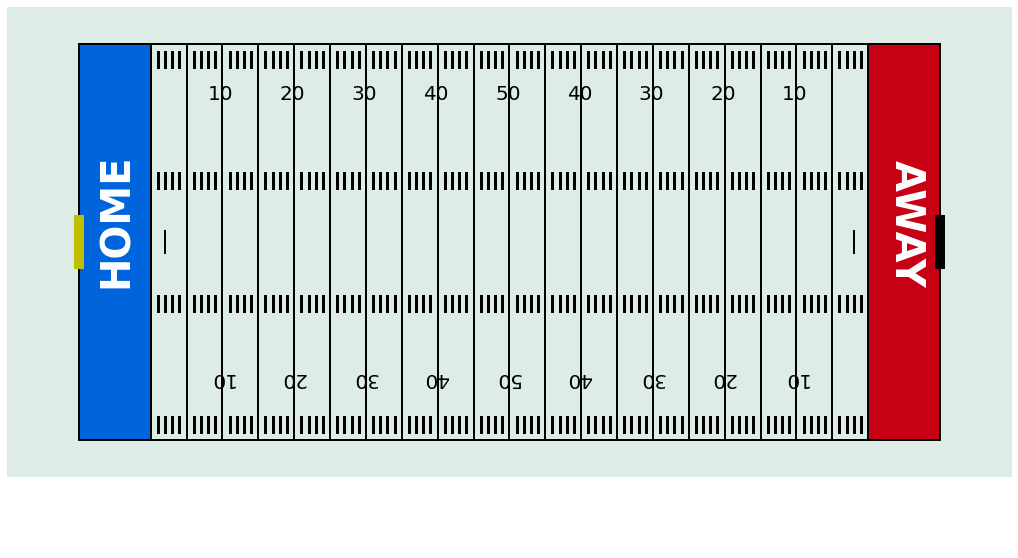

In [194]:
csv = pd.read_csv(playpath)
a,b,c,d,e, lines, times, ox, oy = process_frames(csv, delaunay=True)

In [195]:
from matplotlib import animation
from IPython.display import HTML




def animate_one_play(home, away, balls, return_line, lines,times):
    fig, ax = drawPitch(100, 53.3)
    

    team_left, = ax.plot([], [], 'o', markersize=12, markerfacecolor="r", markeredgewidth=1, markeredgecolor="white", zorder=7)
    team_right, = ax.plot([], [], 'o', markersize=12, markerfacecolor="b", markeredgewidth=1, markeredgecolor="white", zorder=7)
    ball, = ax.plot([], [], 'o', markersize=6, markerfacecolor="black", markeredgewidth=1, markeredgecolor="white", zorder=7)
    returner_line, = ax.plot([],[], "--", zorder=5, c="black")
    returner_path, = ax.plot([], [], "-", zorder=5, c="darkviolet", linewidth=3)
    returner_pos, = ax.plot([], [], 'o', markersize=12, markerfacecolor="gray", markeredgewidth=1, markeredgecolor="white", zorder=7)

#     p = ax.scatter([], [], c=[], cmap="YlOrRd", marker="s", s=5, zorder=15)






    drawings = [team_left, team_right, ball, returner_line, returner_path, returner_pos]

    def init():
        team_left.set_data([], [])
        team_right.set_data([], [])
        ball.set_data([], [])
        returner_line.set_data([],[])
        returner_path.set_data([x[0] for x in return_line], [x[1] for x in return_line])
        returner_pos.set_data([],[])
        return drawings

    def draw_teams(i):
        X = []
        Y = []
        for x,y in home[i]:
            X.append(x)
            Y.append(y)
        team_left.set_data(X, Y)
        
        X = []
        Y = []
        for x,y in away[i]:
            X.append(x)
            Y.append(y)
        team_right.set_data(X, Y)
                
        returner_pos.set_data(return_line[i][0], return_line[i][1])

        

    def animate(i):
        draw_teams(i)
        
        x, y = balls[i]
        ball.set_data([x, y])
        x, y = return_line[i]
        returner_line.set_data([[x, x], [0,53.3]])
        
        return drawings
    
    # !May take a while!
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(balls), interval=100, blit=False)

    return HTML(anim.to_html5_video())

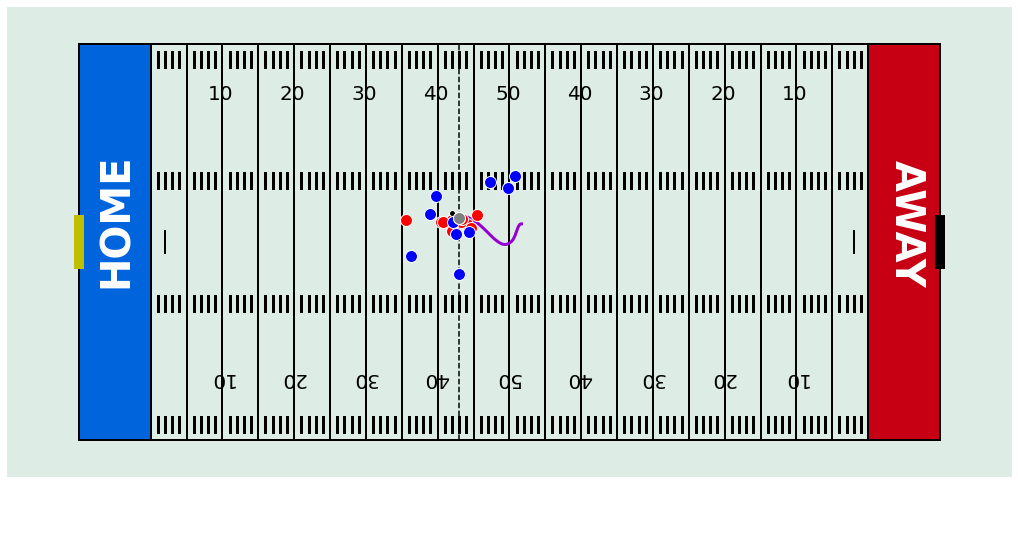

In [196]:
animate_one_play(c,d,e,b, lines,times)

In [190]:
b

[(61.68, 29.08),
 (61.53, 29.07),
 (61.4, 28.96),
 (61.28, 28.78),
 (61.17, 28.54),
 (61.06, 28.24),
 (60.94, 27.92),
 (60.82, 27.58),
 (60.67, 27.27),
 (60.51, 26.97),
 (60.32, 26.74),
 (60.11, 26.57),
 (59.88, 26.43),
 (59.64, 26.33),
 (59.39, 26.3),
 (59.12, 26.33),
 (58.84, 26.43),
 (58.55, 26.58),
 (58.26, 26.78),
 (57.95, 27.02),
 (57.63, 27.3),
 (57.3, 27.62),
 (56.96, 27.95),
 (56.61, 28.28),
 (56.25, 28.61),
 (55.9, 28.92),
 (55.54, 29.2),
 (55.15, 29.44),
 (54.81, 29.67),
 (54.49, 29.83),
 (54.18, 29.98),
 (53.94, 30.05),
 (53.68, 30.13),
 (53.52, 30.12),
 (53.32, 30.14),
 (53.26, 30.08),
 (53.14, 30.07),
 (53.14, 30.01),
 (53.08, 29.99),
 (53.11, 29.95),
 (53.08, 29.94),
 (53.11, 29.9),
 (53.1, 29.9),
 (53.13, 29.87),
 (53.12, 29.87),
 (53.09, 29.87),
 (53.08, 29.87),
 (53.0, 29.89),
 (52.99, 29.89),
 (52.91, 29.9)]